# PRÁCTICA DE SIMULACIÓN - VACUNACION 2.0
### Alejandro Enríquez 
### Ingeniería en Ciencias de la Computación
### 10mo Ciclo

Objetivo: en base a la práctica del COVID vacunación, realizar el proceso de interrupción en base a que el 5% de los pacientes que están en la sala de espera presentan complicaciones de salud y deben ser trasladados inmediatamente al centro de salud más cercano y ser atendidos. Realizar este proceso y generar una segunda linea de simulación para el traslado, atención y alta del paciente que presenta complicaciones, en base a los siguientes datos:

- Traslado de la ambulancia: 5-15 minutos
- Atención centro de salud: 5-24 horas
- Alta: 1-2 horas
- El 10% de las personas que presentan complicaciones fallecen

Generar gráficas que indiquen las personas que presentaron complicaciones en base a los tiempos, estado de las personas y respuesta

In [1]:
# Imports
import simpy
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Instanciar Variables
horas_diarias = 9
minutos_diarios = horas_diarias * 60

TIEMPO_TOTAL = minutos_diarios * 1
NUM_MEDICOS = 6
TIEMPO_VACUNACION = 5 #Hasta 10
INTERVALO_LLEGADA = 5
POST_VACUNA = 20
CERTIFICACION = 2 #Hasta 3
TOTAL_DIAS = 100
ESPERA_INICIAL = 6

vacunados = 0
no_vacunados = 0
pacientes = 0
bandera = 1

proceso = pd.DataFrame(columns=['dia','pacientes','vacunados','no_vacunados'])

In [3]:
# Clase 
class Vacunacion(object):
    def __init__(self, environment, num_medicos, tiempo_vacunacion):
        self.env = environment
        self.medicos = simpy.Resource(environment, num_medicos)
        self.numero_graves = 0
        self.numero_muertos = 0
        self.falla = False
        env.process(self.revisar())
        
    def vacunar(self, paciente):
        complicaciones = random.randint(1,100)
        global vacunados
        global no_vacunados
        global bandera
        if(complicaciones<95):
            tVacunacion = random.randint(TIEMPO_VACUNACION, TIEMPO_VACUNACION+5)
            print("El paciente %s empieza la vacunación a la hora: %.2f." %(paciente, env.now))
            yield self.env.timeout(tVacunacion)
            vacunados+=1
            bandera = 1
        else:
            print("*** El %s No puede vacunarse" % (paciente))
            no_vacunados+=1
            bandera = 0
            
    def revisar(self, paciente):
        global bandera
        print('Empieza espera: %s a la hora %.2f.' % (paciente, env.now))
        tCertificacion = random.randint(CERTIFICACION, CERTIFICACION+1)
        if bandera == 1:
            try:
                yield env.timeout(tCertificacion + POST_VACUNA)
                print("[%s]  se retira vacunado y certificado a las %.2f." % (paciente, env.now))
            except simpy.Interrupt:
                print("[%s] tuvo complicaciones a las %.2f." % (paciente, env.now))
                self.numero_graves += 1
                self.falla = false
                
        else:
            print("[%s]  se retira sin ser vacunado a las %.2f." % (paciente, env.now))
            
    def complicacion(self):
        while True:
            traslado_ambulancia = random.randint(5,15)
            atencion_medica = random.randint(300, 1440)
            alta = random.randint(60, 120)
            fallece = random.randint(1,10)
            
            yield self.env.timeout(traslado_ambulancia + atencion_medica + alta)
            if fallece == 1:
                self.numero_muertos += 1
            self.proceso.interrupt()

In [4]:
# Procesos
def llegada_paciente(env, nombre, vacunacion):
    print("Llega paciente: %s a la hora %.2f." % (nombre, env.now))
    with vacunacion.medicos.request() as medico:
        yield medico
        #print('Empieza vacunación: %s a la hora %.2f.' % (nombre, env.now))
        yield env.process(vacunacion.vacunar(nombre))
        print('La vacunacion de %s terminó a la hora: %.2f.'%(nombre, env.now))
        env.process(vacunacion.revisar(nombre))
        print("[%s]  se retira a las %.2f." % (nombre, env.now))
        
def ejecutar_simulacion(env, num_medicos, tiempo_vacunacion, intervalo):
    global pacientes
    global ESPERA_INICIAL
    vacunacion = Vacunacion(env, num_medicos, tiempo_vacunacion)
    for i in range(ESPERA_INICIAL):
        env.process(llegada_paciente(env, 'Paciente-%d' % (i+1), vacunacion))
        
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+2))
        i+=1   
        env.process(llegada_paciente(env, 'Paciente-%d' % (i+1), vacunacion))
        pacientes = i+1

In [5]:
# Simulación
print("Iniciando vacunacion")
random.seed(76)

for i in range(TOTAL_DIAS):
    env = simpy.Environment()
    print("###Los médicos del día ", i, " son: ", NUM_MEDICOS)
    env.process(ejecutar_simulacion(env, NUM_MEDICOS, TIEMPO_VACUNACION, INTERVALO_LLEGADA))
    env.run(until=minutos_diarios)
    dia = [i+1, pacientes, vacunados, no_vacunados]
    proceso.loc[len(proceso)] = dia
    vacunados = 0
    no_vacunados = 0
    if i >= 30:
        NUM_MEDICOS = 10
        INTERVALO_LLEGADA = 4
    else:
        NUM_MEDICOS = 6
        INTERVALO_LLEGADA = 5
            

Iniciando vacunacion
###Los médicos del día  0  son:  6
Llega paciente: Paciente-1 a la hora 0.00.
Llega paciente: Paciente-2 a la hora 0.00.
Llega paciente: Paciente-3 a la hora 0.00.
Llega paciente: Paciente-4 a la hora 0.00.
Llega paciente: Paciente-5 a la hora 0.00.
Llega paciente: Paciente-6 a la hora 0.00.
El paciente Paciente-1 empieza la vacunación a la hora: 0.00.
El paciente Paciente-2 empieza la vacunación a la hora: 0.00.
El paciente Paciente-3 empieza la vacunación a la hora: 0.00.
El paciente Paciente-4 empieza la vacunación a la hora: 0.00.
El paciente Paciente-5 empieza la vacunación a la hora: 0.00.
El paciente Paciente-6 empieza la vacunación a la hora: 0.00.
Llega paciente: Paciente-7 a la hora 4.00.
Llega paciente: Paciente-8 a la hora 6.00.
La vacunacion de Paciente-6 terminó a la hora: 6.00.
[Paciente-6]  se retira a las 6.00.
Empieza espera: Paciente-6 a la hora 6.00.
El paciente Paciente-7 empieza la vacunación a la hora: 6.00.
La vacunacion de Paciente-2 termin

El paciente Paciente-119 empieza la vacunación a la hora: 492.00.
Llega paciente: Paciente-120 a la hora 494.00.
El paciente Paciente-120 empieza la vacunación a la hora: 494.00.
[Paciente-114]  se retira vacunado y certificado a las 496.00.
Llega paciente: Paciente-121 a la hora 497.00.
La vacunacion de Paciente-118 terminó a la hora: 497.00.
[Paciente-118]  se retira a las 497.00.
Empieza espera: Paciente-118 a la hora 497.00.
El paciente Paciente-121 empieza la vacunación a la hora: 497.00.
La vacunacion de Paciente-119 terminó a la hora: 498.00.
[Paciente-119]  se retira a las 498.00.
Empieza espera: Paciente-119 a la hora 498.00.
La vacunacion de Paciente-120 terminó a la hora: 499.00.
[Paciente-120]  se retira a las 499.00.
Empieza espera: Paciente-120 a la hora 499.00.
Llega paciente: Paciente-122 a la hora 501.00.
El paciente Paciente-122 empieza la vacunación a la hora: 501.00.
Llega paciente: Paciente-123 a la hora 506.00.
El paciente Paciente-123 empieza la vacunación a la h

El paciente Paciente-97 empieza la vacunación a la hora: 395.00.
La vacunacion de Paciente-96 terminó a la hora: 398.00.
[Paciente-96]  se retira a las 398.00.
Empieza espera: Paciente-96 a la hora 398.00.
[Paciente-92]  se retira vacunado y certificado a las 399.00.
Llega paciente: Paciente-98 a la hora 401.00.
El paciente Paciente-98 empieza la vacunación a la hora: 401.00.
La vacunacion de Paciente-97 terminó a la hora: 401.00.
[Paciente-97]  se retira a las 401.00.
Empieza espera: Paciente-97 a la hora 401.00.
[Paciente-93]  se retira vacunado y certificado a las 402.00.
Llega paciente: Paciente-99 a la hora 404.00.
El paciente Paciente-99 empieza la vacunación a la hora: 404.00.
[Paciente-94]  se retira vacunado y certificado a las 405.00.
Llega paciente: Paciente-100 a la hora 406.00.
El paciente Paciente-100 empieza la vacunación a la hora: 406.00.
Llega paciente: Paciente-101 a la hora 409.00.
El paciente Paciente-101 empieza la vacunación a la hora: 409.00.
La vacunacion de Pa

Empieza espera: Paciente-38 a la hora 151.00.
[Paciente-33]  se retira vacunado y certificado a las 154.00.
Llega paciente: Paciente-40 a la hora 155.00.
El paciente Paciente-40 empieza la vacunación a la hora: 155.00.
La vacunacion de Paciente-39 terminó a la hora: 157.00.
[Paciente-39]  se retira a las 157.00.
Empieza espera: Paciente-39 a la hora 157.00.
[Paciente-34]  se retira vacunado y certificado a las 158.00.
Llega paciente: Paciente-41 a la hora 158.00.
El paciente Paciente-41 empieza la vacunación a la hora: 158.00.
La vacunacion de Paciente-40 terminó a la hora: 161.00.
[Paciente-40]  se retira a las 161.00.
Empieza espera: Paciente-40 a la hora 161.00.
[Paciente-35]  se retira vacunado y certificado a las 162.00.
[Paciente-36]  se retira vacunado y certificado a las 162.00.
Llega paciente: Paciente-42 a la hora 163.00.
El paciente Paciente-42 empieza la vacunación a la hora: 163.00.
Llega paciente: Paciente-43 a la hora 166.00.
El paciente Paciente-43 empieza la vacunación

Llega paciente: Paciente-29 a la hora 98.00.
El paciente Paciente-29 empieza la vacunación a la hora: 98.00.
[Paciente-23]  se retira vacunado y certificado a las 102.00.
La vacunacion de Paciente-29 terminó a la hora: 103.00.
[Paciente-29]  se retira a las 103.00.
Empieza espera: Paciente-29 a la hora 103.00.
Llega paciente: Paciente-30 a la hora 104.00.
El paciente Paciente-30 empieza la vacunación a la hora: 104.00.
[Paciente-24]  se retira vacunado y certificado a las 105.00.
La vacunacion de Paciente-28 terminó a la hora: 105.00.
[Paciente-28]  se retira a las 105.00.
Empieza espera: Paciente-28 a la hora 105.00.
[Paciente-25]  se retira vacunado y certificado a las 108.00.
La vacunacion de Paciente-30 terminó a la hora: 109.00.
[Paciente-30]  se retira a las 109.00.
Empieza espera: Paciente-30 a la hora 109.00.
Llega paciente: Paciente-31 a la hora 110.00.
El paciente Paciente-31 empieza la vacunación a la hora: 110.00.
[Paciente-26]  se retira vacunado y certificado a las 111.00

Llega paciente: Paciente-32 a la hora 130.00.
El paciente Paciente-32 empieza la vacunación a la hora: 130.00.
[Paciente-26]  se retira vacunado y certificado a las 133.00.
La vacunacion de Paciente-31 terminó a la hora: 133.00.
[Paciente-31]  se retira a las 133.00.
Empieza espera: Paciente-31 a la hora 133.00.
Llega paciente: Paciente-33 a la hora 134.00.
El paciente Paciente-33 empieza la vacunación a la hora: 134.00.
La vacunacion de Paciente-32 terminó a la hora: 135.00.
[Paciente-32]  se retira a las 135.00.
Empieza espera: Paciente-32 a la hora 135.00.
Llega paciente: Paciente-34 a la hora 136.00.
El paciente Paciente-34 empieza la vacunación a la hora: 136.00.
[Paciente-27]  se retira vacunado y certificado a las 139.00.
La vacunacion de Paciente-33 terminó a la hora: 139.00.
[Paciente-33]  se retira a las 139.00.
Empieza espera: Paciente-33 a la hora 139.00.
Llega paciente: Paciente-35 a la hora 142.00.
El paciente Paciente-35 empieza la vacunación a la hora: 142.00.
[Paciente

Empieza espera: Paciente-36 a la hora 131.00.
La vacunacion de Paciente-37 terminó a la hora: 132.00.
[Paciente-37]  se retira a las 132.00.
Empieza espera: Paciente-37 a la hora 132.00.
La vacunacion de Paciente-38 terminó a la hora: 134.00.
[Paciente-38]  se retira a las 134.00.
Empieza espera: Paciente-38 a la hora 134.00.
[Paciente-32]  se retira vacunado y certificado a las 136.00.
Llega paciente: Paciente-40 a la hora 137.00.
El paciente Paciente-40 empieza la vacunación a la hora: 137.00.
La vacunacion de Paciente-39 terminó a la hora: 137.00.
[Paciente-39]  se retira a las 137.00.
Empieza espera: Paciente-39 a la hora 137.00.
[Paciente-33]  se retira vacunado y certificado a las 140.00.
Llega paciente: Paciente-41 a la hora 140.00.
*** El Paciente-41 No puede vacunarse
La vacunacion de Paciente-41 terminó a la hora: 140.00.
[Paciente-41]  se retira a las 140.00.
Empieza espera: Paciente-41 a la hora 140.00.
[Paciente-41]  se retira sin ser vacunado a las 140.00.
Llega paciente:

La vacunacion de Paciente-81 terminó a la hora: 338.00.
[Paciente-81]  se retira a las 338.00.
Empieza espera: Paciente-81 a la hora 338.00.
Llega paciente: Paciente-83 a la hora 339.00.
El paciente Paciente-83 empieza la vacunación a la hora: 339.00.
[Paciente-75]  se retira vacunado y certificado a las 340.00.
La vacunacion de Paciente-82 terminó a la hora: 342.00.
[Paciente-82]  se retira a las 342.00.
Empieza espera: Paciente-82 a la hora 342.00.
Llega paciente: Paciente-84 a la hora 344.00.
El paciente Paciente-84 empieza la vacunación a la hora: 344.00.
[Paciente-77]  se retira vacunado y certificado a las 345.00.
Llega paciente: Paciente-85 a la hora 346.00.
La vacunacion de Paciente-83 terminó a la hora: 346.00.
[Paciente-83]  se retira a las 346.00.
Empieza espera: Paciente-83 a la hora 346.00.
El paciente Paciente-85 empieza la vacunación a la hora: 346.00.
[Paciente-78]  se retira vacunado y certificado a las 348.00.
Llega paciente: Paciente-86 a la hora 348.00.
El paciente 

La vacunacion de Paciente-24 terminó a la hora: 94.00.
[Paciente-24]  se retira a las 94.00.
Empieza espera: Paciente-24 a la hora 94.00.
El paciente Paciente-26 empieza la vacunación a la hora: 94.00.
[Paciente-19]  se retira vacunado y certificado a las 96.00.
[Paciente-20]  se retira vacunado y certificado a las 98.00.
Llega paciente: Paciente-27 a la hora 99.00.
La vacunacion de Paciente-25 terminó a la hora: 99.00.
[Paciente-25]  se retira a las 99.00.
Empieza espera: Paciente-25 a la hora 99.00.
El paciente Paciente-27 empieza la vacunación a la hora: 99.00.
Llega paciente: Paciente-28 a la hora 104.00.
La vacunacion de Paciente-26 terminó a la hora: 104.00.
[Paciente-26]  se retira a las 104.00.
Empieza espera: Paciente-26 a la hora 104.00.
El paciente Paciente-28 empieza la vacunación a la hora: 104.00.
[Paciente-21]  se retira vacunado y certificado a las 106.00.
La vacunacion de Paciente-27 terminó a la hora: 107.00.
[Paciente-27]  se retira a las 107.00.
Empieza espera: Paci

[Paciente-96]  se retira a las 408.00.
Empieza espera: Paciente-96 a la hora 408.00.
[Paciente-92]  se retira vacunado y certificado a las 410.00.
Llega paciente: Paciente-98 a la hora 415.00.
El paciente Paciente-98 empieza la vacunación a la hora: 415.00.
La vacunacion de Paciente-97 terminó a la hora: 415.00.
[Paciente-97]  se retira a las 415.00.
Empieza espera: Paciente-97 a la hora 415.00.
[Paciente-93]  se retira vacunado y certificado a las 416.00.
Llega paciente: Paciente-99 a la hora 419.00.
El paciente Paciente-99 empieza la vacunación a la hora: 419.00.
Llega paciente: Paciente-100 a la hora 421.00.
El paciente Paciente-100 empieza la vacunación a la hora: 421.00.
La vacunacion de Paciente-98 terminó a la hora: 424.00.
[Paciente-98]  se retira a las 424.00.
Empieza espera: Paciente-98 a la hora 424.00.
Llega paciente: Paciente-101 a la hora 426.00.
*** El Paciente-101 No puede vacunarse
La vacunacion de Paciente-101 terminó a la hora: 426.00.
[Paciente-101]  se retira a las

Empieza espera: Paciente-41 a la hora 162.00.
Llega paciente: Paciente-43 a la hora 165.00.
El paciente Paciente-43 empieza la vacunación a la hora: 165.00.
[Paciente-37]  se retira vacunado y certificado a las 166.00.
La vacunacion de Paciente-42 terminó a la hora: 166.00.
[Paciente-42]  se retira a las 166.00.
Empieza espera: Paciente-42 a la hora 166.00.
Llega paciente: Paciente-44 a la hora 167.00.
El paciente Paciente-44 empieza la vacunación a la hora: 167.00.
[Paciente-38]  se retira vacunado y certificado a las 168.00.
La vacunacion de Paciente-43 terminó a la hora: 170.00.
[Paciente-43]  se retira a las 170.00.
Empieza espera: Paciente-43 a la hora 170.00.
Llega paciente: Paciente-45 a la hora 172.00.
El paciente Paciente-45 empieza la vacunación a la hora: 172.00.
La vacunacion de Paciente-44 terminó a la hora: 174.00.
[Paciente-44]  se retira a las 174.00.
Empieza espera: Paciente-44 a la hora 174.00.
[Paciente-39]  se retira vacunado y certificado a las 175.00.
Llega pacien

El paciente Paciente-110 empieza la vacunación a la hora: 476.00.
La vacunacion de Paciente-109 terminó a la hora: 479.00.
[Paciente-109]  se retira a las 479.00.
Empieza espera: Paciente-109 a la hora 479.00.
[Paciente-104]  se retira vacunado y certificado a las 481.00.
La vacunacion de Paciente-110 terminó a la hora: 481.00.
[Paciente-110]  se retira a las 481.00.
Empieza espera: Paciente-110 a la hora 481.00.
Llega paciente: Paciente-111 a la hora 482.00.
El paciente Paciente-111 empieza la vacunación a la hora: 482.00.
Llega paciente: Paciente-112 a la hora 484.00.
El paciente Paciente-112 empieza la vacunación a la hora: 484.00.
Llega paciente: Paciente-113 a la hora 486.00.
El paciente Paciente-113 empieza la vacunación a la hora: 486.00.
Llega paciente: Paciente-114 a la hora 490.00.
La vacunacion de Paciente-111 terminó a la hora: 490.00.
[Paciente-111]  se retira a las 490.00.
Empieza espera: Paciente-111 a la hora 490.00.
*** El Paciente-114 No puede vacunarse
La vacunacion 

[Paciente-83]  se retira vacunado y certificado a las 400.00.
Llega paciente: Paciente-91 a la hora 401.00.
El paciente Paciente-91 empieza la vacunación a la hora: 401.00.
[Paciente-84]  se retira vacunado y certificado a las 402.00.
La vacunacion de Paciente-90 terminó a la hora: 404.00.
[Paciente-90]  se retira a las 404.00.
Empieza espera: Paciente-90 a la hora 404.00.
[Paciente-85]  se retira vacunado y certificado a las 405.00.
Llega paciente: Paciente-92 a la hora 405.00.
*** El Paciente-92 No puede vacunarse
La vacunacion de Paciente-92 terminó a la hora: 405.00.
[Paciente-92]  se retira a las 405.00.
Empieza espera: Paciente-92 a la hora 405.00.
[Paciente-92]  se retira sin ser vacunado a las 405.00.
La vacunacion de Paciente-91 terminó a la hora: 406.00.
[Paciente-91]  se retira a las 406.00.
Empieza espera: Paciente-91 a la hora 406.00.
[Paciente-86]  se retira vacunado y certificado a las 409.00.
Llega paciente: Paciente-93 a la hora 411.00.
El paciente Paciente-93 empieza 

[Paciente-66]  se retira a las 282.00.
Empieza espera: Paciente-66 a la hora 282.00.
[Paciente-61]  se retira vacunado y certificado a las 284.00.
Llega paciente: Paciente-68 a la hora 284.00.
El paciente Paciente-68 empieza la vacunación a la hora: 284.00.
La vacunacion de Paciente-67 terminó a la hora: 289.00.
[Paciente-67]  se retira a las 289.00.
Empieza espera: Paciente-67 a la hora 289.00.
[Paciente-62]  se retira vacunado y certificado a las 291.00.
Llega paciente: Paciente-69 a la hora 291.00.
El paciente Paciente-69 empieza la vacunación a la hora: 291.00.
[Paciente-63]  se retira vacunado y certificado a las 293.00.
Llega paciente: Paciente-70 a la hora 293.00.
La vacunacion de Paciente-68 terminó a la hora: 293.00.
[Paciente-68]  se retira a las 293.00.
Empieza espera: Paciente-68 a la hora 293.00.
El paciente Paciente-70 empieza la vacunación a la hora: 293.00.
Llega paciente: Paciente-71 a la hora 297.00.
El paciente Paciente-71 empieza la vacunación a la hora: 297.00.
[Pa

[Paciente-1]  se retira a las 7.00.
Empieza espera: Paciente-1 a la hora 7.00.
La vacunacion de Paciente-2 terminó a la hora: 8.00.
[Paciente-2]  se retira a las 8.00.
Empieza espera: Paciente-2 a la hora 8.00.
La vacunacion de Paciente-5 terminó a la hora: 8.00.
[Paciente-5]  se retira a las 8.00.
Empieza espera: Paciente-5 a la hora 8.00.
La vacunacion de Paciente-4 terminó a la hora: 9.00.
[Paciente-4]  se retira a las 9.00.
Empieza espera: Paciente-4 a la hora 9.00.
La vacunacion de Paciente-6 terminó a la hora: 10.00.
[Paciente-6]  se retira a las 10.00.
Empieza espera: Paciente-6 a la hora 10.00.
Llega paciente: Paciente-8 a la hora 12.00.
El paciente Paciente-8 empieza la vacunación a la hora: 12.00.
La vacunacion de Paciente-7 terminó a la hora: 15.00.
[Paciente-7]  se retira a las 15.00.
Empieza espera: Paciente-7 a la hora 15.00.
Llega paciente: Paciente-9 a la hora 19.00.
El paciente Paciente-9 empieza la vacunación a la hora: 19.00.
La vacunacion de Paciente-8 terminó a la 

[Paciente-103]  se retira a las 468.00.
Empieza espera: Paciente-103 a la hora 468.00.
La vacunacion de Paciente-104 terminó a la hora: 469.00.
[Paciente-104]  se retira a las 469.00.
Empieza espera: Paciente-104 a la hora 469.00.
Llega paciente: Paciente-105 a la hora 470.00.
El paciente Paciente-105 empieza la vacunación a la hora: 470.00.
[Paciente-99]  se retira vacunado y certificado a las 471.00.
Llega paciente: Paciente-106 a la hora 473.00.
El paciente Paciente-106 empieza la vacunación a la hora: 473.00.
[Paciente-100]  se retira vacunado y certificado a las 474.00.
[Paciente-101]  se retira vacunado y certificado a las 477.00.
Llega paciente: Paciente-107 a la hora 478.00.
La vacunacion de Paciente-105 terminó a la hora: 478.00.
[Paciente-105]  se retira a las 478.00.
Empieza espera: Paciente-105 a la hora 478.00.
El paciente Paciente-107 empieza la vacunación a la hora: 478.00.
La vacunacion de Paciente-106 terminó a la hora: 478.00.
[Paciente-106]  se retira a las 478.00.
E

[Paciente-38]  se retira vacunado y certificado a las 170.00.
Llega paciente: Paciente-45 a la hora 171.00.
El paciente Paciente-45 empieza la vacunación a la hora: 171.00.
[Paciente-39]  se retira vacunado y certificado a las 173.00.
Llega paciente: Paciente-46 a la hora 175.00.
El paciente Paciente-46 empieza la vacunación a la hora: 175.00.
[Paciente-40]  se retira vacunado y certificado a las 178.00.
[Paciente-42]  se retira vacunado y certificado a las 178.00.
[Paciente-41]  se retira vacunado y certificado a las 179.00.
La vacunacion de Paciente-45 terminó a la hora: 179.00.
[Paciente-45]  se retira a las 179.00.
Empieza espera: Paciente-45 a la hora 179.00.
Llega paciente: Paciente-47 a la hora 182.00.
El paciente Paciente-47 empieza la vacunación a la hora: 182.00.
Llega paciente: Paciente-48 a la hora 184.00.
El paciente Paciente-48 empieza la vacunación a la hora: 184.00.
La vacunacion de Paciente-46 terminó a la hora: 185.00.
[Paciente-46]  se retira a las 185.00.
Empieza es

[Paciente-105]  se retira vacunado y certificado a las 478.00.
La vacunacion de Paciente-109 terminó a la hora: 479.00.
[Paciente-109]  se retira a las 479.00.
Empieza espera: Paciente-109 a la hora 479.00.
Llega paciente: Paciente-112 a la hora 481.00.
El paciente Paciente-112 empieza la vacunación a la hora: 481.00.
La vacunacion de Paciente-110 terminó a la hora: 482.00.
[Paciente-110]  se retira a las 482.00.
Empieza espera: Paciente-110 a la hora 482.00.
La vacunacion de Paciente-111 terminó a la hora: 482.00.
[Paciente-111]  se retira a las 482.00.
Empieza espera: Paciente-111 a la hora 482.00.
[Paciente-106]  se retira vacunado y certificado a las 483.00.
Llega paciente: Paciente-113 a la hora 485.00.
El paciente Paciente-113 empieza la vacunación a la hora: 485.00.
La vacunacion de Paciente-112 terminó a la hora: 487.00.
[Paciente-112]  se retira a las 487.00.
Empieza espera: Paciente-112 a la hora 487.00.
Llega paciente: Paciente-114 a la hora 488.00.
El paciente Paciente-114 

El paciente Paciente-20 empieza la vacunación a la hora: 63.00.
La vacunacion de Paciente-19 terminó a la hora: 63.00.
[Paciente-19]  se retira a las 63.00.
Empieza espera: Paciente-19 a la hora 63.00.
[Paciente-14]  se retira vacunado y certificado a las 66.00.
[Paciente-15]  se retira vacunado y certificado a las 68.00.
Llega paciente: Paciente-21 a la hora 68.00.
El paciente Paciente-21 empieza la vacunación a la hora: 68.00.
La vacunacion de Paciente-20 terminó a la hora: 70.00.
[Paciente-20]  se retira a las 70.00.
Empieza espera: Paciente-20 a la hora 70.00.
Llega paciente: Paciente-22 a la hora 71.00.
El paciente Paciente-22 empieza la vacunación a la hora: 71.00.
[Paciente-16]  se retira vacunado y certificado a las 72.00.
Llega paciente: Paciente-23 a la hora 73.00.
La vacunacion de Paciente-21 terminó a la hora: 73.00.
[Paciente-21]  se retira a las 73.00.
Empieza espera: Paciente-21 a la hora 73.00.
El paciente Paciente-23 empieza la vacunación a la hora: 73.00.
[Paciente-17

Llega paciente: Paciente-65 a la hora 191.00.
El paciente Paciente-65 empieza la vacunación a la hora: 191.00.
La vacunacion de Paciente-64 terminó a la hora: 191.00.
[Paciente-64]  se retira a las 191.00.
Empieza espera: Paciente-64 a la hora 191.00.
[Paciente-58]  se retira vacunado y certificado a las 196.00.
Llega paciente: Paciente-66 a la hora 197.00.
El paciente Paciente-66 empieza la vacunación a la hora: 197.00.
[Paciente-57]  se retira vacunado y certificado a las 198.00.
Llega paciente: Paciente-67 a la hora 200.00.
La vacunacion de Paciente-65 terminó a la hora: 200.00.
[Paciente-65]  se retira a las 200.00.
Empieza espera: Paciente-65 a la hora 200.00.
El paciente Paciente-67 empieza la vacunación a la hora: 200.00.
La vacunacion de Paciente-66 terminó a la hora: 203.00.
[Paciente-66]  se retira a las 203.00.
Empieza espera: Paciente-66 a la hora 203.00.
[Paciente-59]  se retira vacunado y certificado a las 204.00.
[Paciente-60]  se retira vacunado y certificado a las 204.

La vacunacion de Paciente-110 terminó a la hora: 360.00.
[Paciente-110]  se retira a las 360.00.
Empieza espera: Paciente-110 a la hora 360.00.
Llega paciente: Paciente-112 a la hora 361.00.
El paciente Paciente-112 empieza la vacunación a la hora: 361.00.
[Paciente-105]  se retira vacunado y certificado a las 364.00.
La vacunacion de Paciente-111 terminó a la hora: 366.00.
[Paciente-111]  se retira a las 366.00.
Empieza espera: Paciente-111 a la hora 366.00.
Llega paciente: Paciente-113 a la hora 367.00.
El paciente Paciente-113 empieza la vacunación a la hora: 367.00.
[Paciente-106]  se retira vacunado y certificado a las 368.00.
La vacunacion de Paciente-112 terminó a la hora: 370.00.
[Paciente-112]  se retira a las 370.00.
Empieza espera: Paciente-112 a la hora 370.00.
Llega paciente: Paciente-114 a la hora 373.00.
El paciente Paciente-114 empieza la vacunación a la hora: 373.00.
La vacunacion de Paciente-113 terminó a la hora: 373.00.
[Paciente-113]  se retira a las 373.00.
Empiez

Empieza espera: Paciente-76 a la hora 268.00.
Llega paciente: Paciente-78 a la hora 270.00.
El paciente Paciente-78 empieza la vacunación a la hora: 270.00.
La vacunacion de Paciente-77 terminó a la hora: 271.00.
[Paciente-77]  se retira a las 271.00.
Empieza espera: Paciente-77 a la hora 271.00.
[Paciente-72]  se retira vacunado y certificado a las 275.00.
[Paciente-73]  se retira vacunado y certificado a las 275.00.
La vacunacion de Paciente-78 terminó a la hora: 275.00.
[Paciente-78]  se retira a las 275.00.
Empieza espera: Paciente-78 a la hora 275.00.
Llega paciente: Paciente-79 a la hora 276.00.
El paciente Paciente-79 empieza la vacunación a la hora: 276.00.
Llega paciente: Paciente-80 a la hora 278.00.
El paciente Paciente-80 empieza la vacunación a la hora: 278.00.
Llega paciente: Paciente-81 a la hora 279.00.
El paciente Paciente-81 empieza la vacunación a la hora: 279.00.
[Paciente-74]  se retira vacunado y certificado a las 281.00.
Llega paciente: Paciente-82 a la hora 282.

[Paciente-20]  se retira vacunado y certificado a las 82.00.
Llega paciente: Paciente-28 a la hora 84.00.
La vacunacion de Paciente-26 terminó a la hora: 84.00.
[Paciente-26]  se retira a las 84.00.
Empieza espera: Paciente-26 a la hora 84.00.
El paciente Paciente-28 empieza la vacunación a la hora: 84.00.
Llega paciente: Paciente-29 a la hora 85.00.
El paciente Paciente-29 empieza la vacunación a la hora: 85.00.
La vacunacion de Paciente-27 terminó a la hora: 87.00.
[Paciente-27]  se retira a las 87.00.
Empieza espera: Paciente-27 a la hora 87.00.
La vacunacion de Paciente-28 terminó a la hora: 90.00.
[Paciente-28]  se retira a las 90.00.
Empieza espera: Paciente-28 a la hora 90.00.
Llega paciente: Paciente-30 a la hora 91.00.
El paciente Paciente-30 empieza la vacunación a la hora: 91.00.
[Paciente-23]  se retira vacunado y certificado a las 93.00.
La vacunacion de Paciente-29 terminó a la hora: 94.00.
[Paciente-29]  se retira a las 94.00.
Empieza espera: Paciente-29 a la hora 94.00.

Empieza espera: Paciente-102 a la hora 377.00.
La vacunacion de Paciente-100 terminó a la hora: 378.00.
[Paciente-100]  se retira a las 378.00.
Empieza espera: Paciente-100 a la hora 378.00.
La vacunacion de Paciente-101 terminó a la hora: 378.00.
[Paciente-101]  se retira a las 378.00.
Empieza espera: Paciente-101 a la hora 378.00.
Llega paciente: Paciente-105 a la hora 379.00.
El paciente Paciente-105 empieza la vacunación a la hora: 379.00.
[Paciente-97]  se retira vacunado y certificado a las 380.00.
[Paciente-96]  se retira vacunado y certificado a las 381.00.
La vacunacion de Paciente-103 terminó a la hora: 381.00.
[Paciente-103]  se retira a las 381.00.
Empieza espera: Paciente-103 a la hora 381.00.
La vacunacion de Paciente-104 terminó a la hora: 382.00.
[Paciente-104]  se retira a las 382.00.
Empieza espera: Paciente-104 a la hora 382.00.
Llega paciente: Paciente-106 a la hora 383.00.
El paciente Paciente-106 empieza la vacunación a la hora: 383.00.
La vacunacion de Paciente-1

El paciente Paciente-44 empieza la vacunación a la hora: 119.00.
La vacunacion de Paciente-41 terminó a la hora: 120.00.
[Paciente-41]  se retira a las 120.00.
Empieza espera: Paciente-41 a la hora 120.00.
La vacunacion de Paciente-40 terminó a la hora: 121.00.
[Paciente-40]  se retira a las 121.00.
Empieza espera: Paciente-40 a la hora 121.00.
Llega paciente: Paciente-45 a la hora 122.00.
El paciente Paciente-45 empieza la vacunación a la hora: 122.00.
Llega paciente: Paciente-46 a la hora 123.00.
El paciente Paciente-46 empieza la vacunación a la hora: 123.00.
[Paciente-36]  se retira vacunado y certificado a las 125.00.
Llega paciente: Paciente-47 a la hora 126.00.
El paciente Paciente-47 empieza la vacunación a la hora: 126.00.
Llega paciente: Paciente-48 a la hora 127.00.
El paciente Paciente-48 empieza la vacunación a la hora: 127.00.
[Paciente-35]  se retira vacunado y certificado a las 128.00.
Llega paciente: Paciente-49 a la hora 128.00.
El paciente Paciente-49 empieza la vacu

Empieza espera: Paciente-105 a la hora 348.00.
[Paciente-97]  se retira vacunado y certificado a las 349.00.
[Paciente-98]  se retira vacunado y certificado a las 351.00.
La vacunacion de Paciente-107 terminó a la hora: 351.00.
[Paciente-107]  se retira a las 351.00.
Empieza espera: Paciente-107 a la hora 351.00.
[Paciente-100]  se retira vacunado y certificado a las 352.00.
[Paciente-99]  se retira vacunado y certificado a las 353.00.
Llega paciente: Paciente-109 a la hora 353.00.
El paciente Paciente-109 empieza la vacunación a la hora: 353.00.
[Paciente-101]  se retira vacunado y certificado a las 355.00.
La vacunacion de Paciente-108 terminó a la hora: 356.00.
[Paciente-108]  se retira a las 356.00.
Empieza espera: Paciente-108 a la hora 356.00.
Llega paciente: Paciente-110 a la hora 357.00.
El paciente Paciente-110 empieza la vacunación a la hora: 357.00.
[Paciente-102]  se retira vacunado y certificado a las 359.00.
[Paciente-103]  se retira vacunado y certificado a las 359.00.
L

La vacunacion de Paciente-32 terminó a la hora: 95.00.
[Paciente-32]  se retira a las 95.00.
Empieza espera: Paciente-32 a la hora 95.00.
El paciente Paciente-34 empieza la vacunación a la hora: 95.00.
La vacunacion de Paciente-33 terminó a la hora: 97.00.
[Paciente-33]  se retira a las 97.00.
Empieza espera: Paciente-33 a la hora 97.00.
[Paciente-26]  se retira vacunado y certificado a las 98.00.
[Paciente-28]  se retira vacunado y certificado a las 98.00.
Llega paciente: Paciente-35 a la hora 99.00.
El paciente Paciente-35 empieza la vacunación a la hora: 99.00.
La vacunacion de Paciente-34 terminó a la hora: 100.00.
[Paciente-34]  se retira a las 100.00.
Empieza espera: Paciente-34 a la hora 100.00.
[Paciente-27]  se retira vacunado y certificado a las 101.00.
[Paciente-29]  se retira vacunado y certificado a las 101.00.
Llega paciente: Paciente-36 a la hora 103.00.
El paciente Paciente-36 empieza la vacunación a la hora: 103.00.
La vacunacion de Paciente-35 terminó a la hora: 105.0

[Paciente-73]  se retira a las 251.00.
Empieza espera: Paciente-73 a la hora 251.00.
[Paciente-68]  se retira vacunado y certificado a las 252.00.
Llega paciente: Paciente-75 a la hora 255.00.
El paciente Paciente-75 empieza la vacunación a la hora: 255.00.
La vacunacion de Paciente-74 terminó a la hora: 255.00.
[Paciente-74]  se retira a las 255.00.
Empieza espera: Paciente-74 a la hora 255.00.
Llega paciente: Paciente-76 a la hora 257.00.
El paciente Paciente-76 empieza la vacunación a la hora: 257.00.
[Paciente-69]  se retira vacunado y certificado a las 258.00.
Llega paciente: Paciente-77 a la hora 260.00.
El paciente Paciente-77 empieza la vacunación a la hora: 260.00.
Llega paciente: Paciente-78 a la hora 261.00.
La vacunacion de Paciente-75 terminó a la hora: 261.00.
[Paciente-75]  se retira a las 261.00.
Empieza espera: Paciente-75 a la hora 261.00.
El paciente Paciente-78 empieza la vacunación a la hora: 261.00.
[Paciente-71]  se retira vacunado y certificado a las 266.00.
Lle

Empieza espera: Paciente-153 a la hora 531.00.
Llega paciente: Paciente-155 a la hora 533.00.
El paciente Paciente-155 empieza la vacunación a la hora: 533.00.
[Paciente-148]  se retira vacunado y certificado a las 536.00.
[Paciente-149]  se retira vacunado y certificado a las 536.00.
La vacunacion de Paciente-154 terminó a la hora: 537.00.
[Paciente-154]  se retira a las 537.00.
Empieza espera: Paciente-154 a la hora 537.00.
La vacunacion de Paciente-155 terminó a la hora: 538.00.
[Paciente-155]  se retira a las 538.00.
Empieza espera: Paciente-155 a la hora 538.00.
Llega paciente: Paciente-156 a la hora 539.00.
El paciente Paciente-156 empieza la vacunación a la hora: 539.00.
###Los médicos del día  45  son:  10
Llega paciente: Paciente-1 a la hora 0.00.
Llega paciente: Paciente-2 a la hora 0.00.
Llega paciente: Paciente-3 a la hora 0.00.
Llega paciente: Paciente-4 a la hora 0.00.
Llega paciente: Paciente-5 a la hora 0.00.
Llega paciente: Paciente-6 a la hora 0.00.
El paciente Pacien

Empieza espera: Paciente-75 a la hora 274.00.
Llega paciente: Paciente-78 a la hora 275.00.
El paciente Paciente-78 empieza la vacunación a la hora: 275.00.
Llega paciente: Paciente-79 a la hora 277.00.
El paciente Paciente-79 empieza la vacunación a la hora: 277.00.
La vacunacion de Paciente-76 terminó a la hora: 278.00.
[Paciente-76]  se retira a las 278.00.
Empieza espera: Paciente-76 a la hora 278.00.
[Paciente-71]  se retira vacunado y certificado a las 279.00.
[Paciente-72]  se retira vacunado y certificado a las 282.00.
Llega paciente: Paciente-80 a la hora 282.00.
La vacunacion de Paciente-77 terminó a la hora: 282.00.
[Paciente-77]  se retira a las 282.00.
Empieza espera: Paciente-77 a la hora 282.00.
El paciente Paciente-80 empieza la vacunación a la hora: 282.00.
La vacunacion de Paciente-79 terminó a la hora: 282.00.
[Paciente-79]  se retira a las 282.00.
Empieza espera: Paciente-79 a la hora 282.00.
Llega paciente: Paciente-81 a la hora 283.00.
El paciente Paciente-81 empi

Llega paciente: Paciente-123 a la hora 412.00.
El paciente Paciente-123 empieza la vacunación a la hora: 412.00.
La vacunacion de Paciente-122 terminó a la hora: 412.00.
[Paciente-122]  se retira a las 412.00.
Empieza espera: Paciente-122 a la hora 412.00.
[Paciente-113]  se retira vacunado y certificado a las 413.00.
[Paciente-115]  se retira vacunado y certificado a las 414.00.
[Paciente-114]  se retira vacunado y certificado a las 414.00.
Llega paciente: Paciente-124 a la hora 415.00.
El paciente Paciente-124 empieza la vacunación a la hora: 415.00.
La vacunacion de Paciente-123 terminó a la hora: 417.00.
[Paciente-123]  se retira a las 417.00.
Empieza espera: Paciente-123 a la hora 417.00.
[Paciente-117]  se retira vacunado y certificado a las 420.00.
Llega paciente: Paciente-125 a la hora 420.00.
El paciente Paciente-125 empieza la vacunación a la hora: 420.00.
La vacunacion de Paciente-124 terminó a la hora: 424.00.
[Paciente-124]  se retira a las 424.00.
Empieza espera: Paciente

Empieza espera: Paciente-37 a la hora 108.00.
Llega paciente: Paciente-39 a la hora 111.00.
El paciente Paciente-39 empieza la vacunación a la hora: 111.00.
La vacunacion de Paciente-38 terminó a la hora: 111.00.
[Paciente-38]  se retira a las 111.00.
Empieza espera: Paciente-38 a la hora 111.00.
[Paciente-33]  se retira vacunado y certificado a las 112.00.
Llega paciente: Paciente-40 a la hora 112.00.
El paciente Paciente-40 empieza la vacunación a la hora: 112.00.
[Paciente-34]  se retira vacunado y certificado a las 114.00.
Llega paciente: Paciente-41 a la hora 115.00.
El paciente Paciente-41 empieza la vacunación a la hora: 115.00.
Llega paciente: Paciente-42 a la hora 116.00.
La vacunacion de Paciente-39 terminó a la hora: 116.00.
[Paciente-39]  se retira a las 116.00.
Empieza espera: Paciente-39 a la hora 116.00.
El paciente Paciente-42 empieza la vacunación a la hora: 116.00.
[Paciente-35]  se retira vacunado y certificado a las 120.00.
Llega paciente: Paciente-43 a la hora 120.

Llega paciente: Paciente-90 a la hora 276.00.
El paciente Paciente-90 empieza la vacunación a la hora: 276.00.
La vacunacion de Paciente-88 terminó a la hora: 278.00.
[Paciente-88]  se retira a las 278.00.
Empieza espera: Paciente-88 a la hora 278.00.
[Paciente-83]  se retira vacunado y certificado a las 281.00.
Llega paciente: Paciente-91 a la hora 281.00.
La vacunacion de Paciente-89 terminó a la hora: 281.00.
[Paciente-89]  se retira a las 281.00.
Empieza espera: Paciente-89 a la hora 281.00.
El paciente Paciente-91 empieza la vacunación a la hora: 281.00.
Llega paciente: Paciente-92 a la hora 283.00.
El paciente Paciente-92 empieza la vacunación a la hora: 283.00.
La vacunacion de Paciente-90 terminó a la hora: 285.00.
[Paciente-90]  se retira a las 285.00.
Empieza espera: Paciente-90 a la hora 285.00.
[Paciente-84]  se retira vacunado y certificado a las 287.00.
[Paciente-85]  se retira vacunado y certificado a las 287.00.
Llega paciente: Paciente-93 a la hora 287.00.
El paciente 

Empieza espera: Paciente-4 a la hora 7.00.
La vacunacion de Paciente-3 terminó a la hora: 8.00.
[Paciente-3]  se retira a las 8.00.
Empieza espera: Paciente-3 a la hora 8.00.
La vacunacion de Paciente-5 terminó a la hora: 9.00.
[Paciente-5]  se retira a las 9.00.
Empieza espera: Paciente-5 a la hora 9.00.
La vacunacion de Paciente-7 terminó a la hora: 9.00.
[Paciente-7]  se retira a las 9.00.
Empieza espera: Paciente-7 a la hora 9.00.
Llega paciente: Paciente-9 a la hora 11.00.
El paciente Paciente-9 empieza la vacunación a la hora: 11.00.
La vacunacion de Paciente-8 terminó a la hora: 15.00.
[Paciente-8]  se retira a las 15.00.
Empieza espera: Paciente-8 a la hora 15.00.
Llega paciente: Paciente-10 a la hora 16.00.
El paciente Paciente-10 empieza la vacunación a la hora: 16.00.
Llega paciente: Paciente-11 a la hora 21.00.
La vacunacion de Paciente-9 terminó a la hora: 21.00.
[Paciente-9]  se retira a las 21.00.
Empieza espera: Paciente-9 a la hora 21.00.
El paciente Paciente-11 empiez

La vacunacion de Paciente-59 terminó a la hora: 190.00.
[Paciente-59]  se retira a las 190.00.
Empieza espera: Paciente-59 a la hora 190.00.
[Paciente-53]  se retira vacunado y certificado a las 192.00.
Llega paciente: Paciente-61 a la hora 195.00.
El paciente Paciente-61 empieza la vacunación a la hora: 195.00.
[Paciente-54]  se retira vacunado y certificado a las 196.00.
[Paciente-55]  se retira vacunado y certificado a las 197.00.
Llega paciente: Paciente-62 a la hora 197.00.
El paciente Paciente-62 empieza la vacunación a la hora: 197.00.
La vacunacion de Paciente-60 terminó a la hora: 199.00.
[Paciente-60]  se retira a las 199.00.
Empieza espera: Paciente-60 a la hora 199.00.
Llega paciente: Paciente-63 a la hora 202.00.
La vacunacion de Paciente-61 terminó a la hora: 202.00.
[Paciente-61]  se retira a las 202.00.
Empieza espera: Paciente-61 a la hora 202.00.
El paciente Paciente-63 empieza la vacunación a la hora: 202.00.
[Paciente-56]  se retira vacunado y certificado a las 204.

Llega paciente: Paciente-95 a la hora 330.00.
El paciente Paciente-95 empieza la vacunación a la hora: 330.00.
[Paciente-86]  se retira vacunado y certificado a las 331.00.
Llega paciente: Paciente-96 a la hora 331.00.
El paciente Paciente-96 empieza la vacunación a la hora: 331.00.
La vacunacion de Paciente-92 terminó a la hora: 333.00.
[Paciente-92]  se retira a las 333.00.
Empieza espera: Paciente-92 a la hora 333.00.
Llega paciente: Paciente-97 a la hora 335.00.
La vacunacion de Paciente-93 terminó a la hora: 335.00.
[Paciente-93]  se retira a las 335.00.
Empieza espera: Paciente-93 a la hora 335.00.
La vacunacion de Paciente-94 terminó a la hora: 335.00.
[Paciente-94]  se retira a las 335.00.
Empieza espera: Paciente-94 a la hora 335.00.
El paciente Paciente-97 empieza la vacunación a la hora: 335.00.
La vacunacion de Paciente-95 terminó a la hora: 338.00.
[Paciente-95]  se retira a las 338.00.
Empieza espera: Paciente-95 a la hora 338.00.
La vacunacion de Paciente-96 terminó a la

[Paciente-150]  se retira vacunado y certificado a las 532.00.
[Paciente-152]  se retira vacunado y certificado a las 533.00.
Llega paciente: Paciente-161 a la hora 533.00.
La vacunacion de Paciente-158 terminó a la hora: 533.00.
[Paciente-158]  se retira a las 533.00.
Empieza espera: Paciente-158 a la hora 533.00.
El paciente Paciente-161 empieza la vacunación a la hora: 533.00.
La vacunacion de Paciente-160 terminó a la hora: 534.00.
[Paciente-160]  se retira a las 534.00.
Empieza espera: Paciente-160 a la hora 534.00.
[Paciente-153]  se retira vacunado y certificado a las 537.00.
La vacunacion de Paciente-159 terminó a la hora: 537.00.
[Paciente-159]  se retira a las 537.00.
Empieza espera: Paciente-159 a la hora 537.00.
Llega paciente: Paciente-162 a la hora 539.00.
El paciente Paciente-162 empieza la vacunación a la hora: 539.00.
###Los médicos del día  56  son:  10
Llega paciente: Paciente-1 a la hora 0.00.
Llega paciente: Paciente-2 a la hora 0.00.
Llega paciente: Paciente-3 a l

Llega paciente: Paciente-39 a la hora 114.00.
El paciente Paciente-39 empieza la vacunación a la hora: 114.00.
La vacunacion de Paciente-37 terminó a la hora: 115.00.
[Paciente-37]  se retira a las 115.00.
Empieza espera: Paciente-37 a la hora 115.00.
Llega paciente: Paciente-40 a la hora 116.00.
El paciente Paciente-40 empieza la vacunación a la hora: 116.00.
[Paciente-31]  se retira vacunado y certificado a las 117.00.
La vacunacion de Paciente-38 terminó a la hora: 119.00.
[Paciente-38]  se retira a las 119.00.
Empieza espera: Paciente-38 a la hora 119.00.
La vacunacion de Paciente-39 terminó a la hora: 120.00.
[Paciente-39]  se retira a las 120.00.
Empieza espera: Paciente-39 a la hora 120.00.
Llega paciente: Paciente-41 a la hora 121.00.
El paciente Paciente-41 empieza la vacunación a la hora: 121.00.
[Paciente-33]  se retira vacunado y certificado a las 123.00.
[Paciente-32]  se retira vacunado y certificado a las 124.00.
Llega paciente: Paciente-42 a la hora 124.00.
El paciente 

La vacunacion de Paciente-71 terminó a la hora: 258.00.
[Paciente-71]  se retira a las 258.00.
Empieza espera: Paciente-71 a la hora 258.00.
Llega paciente: Paciente-74 a la hora 259.00.
El paciente Paciente-74 empieza la vacunación a la hora: 259.00.
Llega paciente: Paciente-75 a la hora 262.00.
El paciente Paciente-75 empieza la vacunación a la hora: 262.00.
La vacunacion de Paciente-74 terminó a la hora: 266.00.
[Paciente-74]  se retira a las 266.00.
Empieza espera: Paciente-74 a la hora 266.00.
[Paciente-65]  se retira vacunado y certificado a las 267.00.
Llega paciente: Paciente-76 a la hora 267.00.
El paciente Paciente-76 empieza la vacunación a la hora: 267.00.
[Paciente-67]  se retira vacunado y certificado a las 269.00.
[Paciente-66]  se retira vacunado y certificado a las 270.00.
Llega paciente: Paciente-77 a la hora 270.00.
La vacunacion de Paciente-75 terminó a la hora: 270.00.
[Paciente-75]  se retira a las 270.00.
Empieza espera: Paciente-75 a la hora 270.00.
El paciente 

Empieza espera: Paciente-98 a la hora 338.00.
[Paciente-92]  se retira vacunado y certificado a las 339.00.
La vacunacion de Paciente-97 terminó a la hora: 340.00.
[Paciente-97]  se retira a las 340.00.
Empieza espera: Paciente-97 a la hora 340.00.
[Paciente-91]  se retira vacunado y certificado a las 342.00.
Llega paciente: Paciente-100 a la hora 342.00.
El paciente Paciente-100 empieza la vacunación a la hora: 342.00.
[Paciente-93]  se retira vacunado y certificado a las 347.00.
Llega paciente: Paciente-101 a la hora 347.00.
La vacunacion de Paciente-99 terminó a la hora: 347.00.
[Paciente-99]  se retira a las 347.00.
Empieza espera: Paciente-99 a la hora 347.00.
El paciente Paciente-101 empieza la vacunación a la hora: 347.00.
Llega paciente: Paciente-102 a la hora 348.00.
El paciente Paciente-102 empieza la vacunación a la hora: 348.00.
[Paciente-94]  se retira vacunado y certificado a las 350.00.
Llega paciente: Paciente-103 a la hora 350.00.
El paciente Paciente-103 empieza la va

La vacunacion de Paciente-135 terminó a la hora: 496.00.
[Paciente-135]  se retira a las 496.00.
Empieza espera: Paciente-135 a la hora 496.00.
Llega paciente: Paciente-138 a la hora 499.00.
La vacunacion de Paciente-136 terminó a la hora: 499.00.
[Paciente-136]  se retira a las 499.00.
Empieza espera: Paciente-136 a la hora 499.00.
El paciente Paciente-138 empieza la vacunación a la hora: 499.00.
La vacunacion de Paciente-137 terminó a la hora: 499.00.
[Paciente-137]  se retira a las 499.00.
Empieza espera: Paciente-137 a la hora 499.00.
Llega paciente: Paciente-139 a la hora 501.00.
El paciente Paciente-139 empieza la vacunación a la hora: 501.00.
[Paciente-130]  se retira vacunado y certificado a las 502.00.
Llega paciente: Paciente-140 a la hora 502.00.
El paciente Paciente-140 empieza la vacunación a la hora: 502.00.
[Paciente-131]  se retira vacunado y certificado a las 504.00.
Llega paciente: Paciente-141 a la hora 505.00.
La vacunacion de Paciente-138 terminó a la hora: 505.00.

[Paciente-22]  se retira a las 58.00.
Empieza espera: Paciente-22 a la hora 58.00.
La vacunacion de Paciente-23 terminó a la hora: 58.00.
[Paciente-23]  se retira a las 58.00.
Empieza espera: Paciente-23 a la hora 58.00.
[Paciente-14]  se retira vacunado y certificado a las 59.00.
Llega paciente: Paciente-24 a la hora 59.00.
El paciente Paciente-24 empieza la vacunación a la hora: 59.00.
[Paciente-16]  se retira vacunado y certificado a las 62.00.
[Paciente-15]  se retira vacunado y certificado a las 62.00.
Llega paciente: Paciente-25 a la hora 64.00.
El paciente Paciente-25 empieza la vacunación a la hora: 64.00.
[Paciente-17]  se retira vacunado y certificado a las 66.00.
La vacunacion de Paciente-24 terminó a la hora: 66.00.
[Paciente-24]  se retira a las 66.00.
Empieza espera: Paciente-24 a la hora 66.00.
[Paciente-18]  se retira vacunado y certificado a las 69.00.
Llega paciente: Paciente-26 a la hora 69.00.
El paciente Paciente-26 empieza la vacunación a la hora: 69.00.
La vacuna

###Los médicos del día  64  son:  10
Llega paciente: Paciente-1 a la hora 0.00.
Llega paciente: Paciente-2 a la hora 0.00.
Llega paciente: Paciente-3 a la hora 0.00.
Llega paciente: Paciente-4 a la hora 0.00.
Llega paciente: Paciente-5 a la hora 0.00.
Llega paciente: Paciente-6 a la hora 0.00.
El paciente Paciente-1 empieza la vacunación a la hora: 0.00.
El paciente Paciente-2 empieza la vacunación a la hora: 0.00.
El paciente Paciente-3 empieza la vacunación a la hora: 0.00.
El paciente Paciente-4 empieza la vacunación a la hora: 0.00.
El paciente Paciente-5 empieza la vacunación a la hora: 0.00.
El paciente Paciente-6 empieza la vacunación a la hora: 0.00.
Llega paciente: Paciente-7 a la hora 3.00.
El paciente Paciente-7 empieza la vacunación a la hora: 3.00.
Llega paciente: Paciente-8 a la hora 5.00.
La vacunacion de Paciente-5 terminó a la hora: 5.00.
[Paciente-5]  se retira a las 5.00.
Empieza espera: Paciente-5 a la hora 5.00.
La vacunacion de Paciente-6 terminó a la hora: 5.00.


Llega paciente: Paciente-45 a la hora 120.00.
El paciente Paciente-45 empieza la vacunación a la hora: 120.00.
Llega paciente: Paciente-46 a la hora 121.00.
El paciente Paciente-46 empieza la vacunación a la hora: 121.00.
La vacunacion de Paciente-43 terminó a la hora: 122.00.
[Paciente-43]  se retira a las 122.00.
Empieza espera: Paciente-43 a la hora 122.00.
[Paciente-34]  se retira vacunado y certificado a las 123.00.
Llega paciente: Paciente-47 a la hora 125.00.
La vacunacion de Paciente-45 terminó a la hora: 125.00.
[Paciente-45]  se retira a las 125.00.
Empieza espera: Paciente-45 a la hora 125.00.
El paciente Paciente-47 empieza la vacunación a la hora: 125.00.
[Paciente-37]  se retira vacunado y certificado a las 126.00.
La vacunacion de Paciente-44 terminó a la hora: 126.00.
[Paciente-44]  se retira a las 126.00.
Empieza espera: Paciente-44 a la hora 126.00.
Llega paciente: Paciente-48 a la hora 127.00.
El paciente Paciente-48 empieza la vacunación a la hora: 127.00.
La vacuna

[Paciente-118]  se retira vacunado y certificado a las 426.00.
Llega paciente: Paciente-126 a la hora 428.00.
La vacunacion de Paciente-124 terminó a la hora: 428.00.
[Paciente-124]  se retira a las 428.00.
Empieza espera: Paciente-124 a la hora 428.00.
El paciente Paciente-126 empieza la vacunación a la hora: 428.00.
[Paciente-119]  se retira vacunado y certificado a las 429.00.
Llega paciente: Paciente-127 a la hora 429.00.
El paciente Paciente-127 empieza la vacunación a la hora: 429.00.
La vacunacion de Paciente-125 terminó a la hora: 430.00.
[Paciente-125]  se retira a las 430.00.
Empieza espera: Paciente-125 a la hora 430.00.
[Paciente-120]  se retira vacunado y certificado a las 434.00.
Llega paciente: Paciente-128 a la hora 434.00.
El paciente Paciente-128 empieza la vacunación a la hora: 434.00.
La vacunacion de Paciente-126 terminó a la hora: 436.00.
[Paciente-126]  se retira a las 436.00.
Empieza espera: Paciente-126 a la hora 436.00.
La vacunacion de Paciente-127 terminó a 

Empieza espera: Paciente-5 a la hora 6.00.
El paciente Paciente-8 empieza la vacunación a la hora: 6.00.
La vacunacion de Paciente-4 terminó a la hora: 7.00.
[Paciente-4]  se retira a las 7.00.
Empieza espera: Paciente-4 a la hora 7.00.
La vacunacion de Paciente-6 terminó a la hora: 7.00.
[Paciente-6]  se retira a las 7.00.
Empieza espera: Paciente-6 a la hora 7.00.
La vacunacion de Paciente-2 terminó a la hora: 8.00.
[Paciente-2]  se retira a las 8.00.
Empieza espera: Paciente-2 a la hora 8.00.
La vacunacion de Paciente-3 terminó a la hora: 9.00.
[Paciente-3]  se retira a las 9.00.
Empieza espera: Paciente-3 a la hora 9.00.
La vacunacion de Paciente-8 terminó a la hora: 11.00.
[Paciente-8]  se retira a las 11.00.
Empieza espera: Paciente-8 a la hora 11.00.
Llega paciente: Paciente-9 a la hora 12.00.
El paciente Paciente-9 empieza la vacunación a la hora: 12.00.
Llega paciente: Paciente-10 a la hora 15.00.
La vacunacion de Paciente-7 terminó a la hora: 15.00.
[Paciente-7]  se retira a 

[Paciente-57]  se retira a las 187.00.
Empieza espera: Paciente-57 a la hora 187.00.
El paciente Paciente-59 empieza la vacunación a la hora: 187.00.
[Paciente-50]  se retira vacunado y certificado a las 189.00.
Llega paciente: Paciente-60 a la hora 192.00.
El paciente Paciente-60 empieza la vacunación a la hora: 192.00.
La vacunacion de Paciente-59 terminó a la hora: 192.00.
[Paciente-59]  se retira a las 192.00.
Empieza espera: Paciente-59 a la hora 192.00.
[Paciente-51]  se retira vacunado y certificado a las 193.00.
[Paciente-52]  se retira vacunado y certificado a las 193.00.
La vacunacion de Paciente-58 terminó a la hora: 194.00.
[Paciente-58]  se retira a las 194.00.
Empieza espera: Paciente-58 a la hora 194.00.
Llega paciente: Paciente-61 a la hora 195.00.
El paciente Paciente-61 empieza la vacunación a la hora: 195.00.
Llega paciente: Paciente-62 a la hora 199.00.
El paciente Paciente-62 empieza la vacunación a la hora: 199.00.
[Paciente-55]  se retira vacunado y certificado a

[Paciente-96]  se retira vacunado y certificado a las 352.00.
La vacunacion de Paciente-100 terminó a la hora: 353.00.
[Paciente-100]  se retira a las 353.00.
Empieza espera: Paciente-100 a la hora 353.00.
[Paciente-94]  se retira vacunado y certificado a las 354.00.
Llega paciente: Paciente-102 a la hora 356.00.
El paciente Paciente-102 empieza la vacunación a la hora: 356.00.
La vacunacion de Paciente-101 terminó a la hora: 358.00.
[Paciente-101]  se retira a las 358.00.
Empieza espera: Paciente-101 a la hora 358.00.
[Paciente-97]  se retira vacunado y certificado a las 360.00.
Llega paciente: Paciente-103 a la hora 360.00.
El paciente Paciente-103 empieza la vacunación a la hora: 360.00.
Llega paciente: Paciente-104 a la hora 364.00.
El paciente Paciente-104 empieza la vacunación a la hora: 364.00.
La vacunacion de Paciente-102 terminó a la hora: 365.00.
[Paciente-102]  se retira a las 365.00.
Empieza espera: Paciente-102 a la hora 365.00.
[Paciente-98]  se retira vacunado y certifi

[Paciente-14]  se retira vacunado y certificado a las 55.00.
Llega paciente: Paciente-23 a la hora 56.00.
El paciente Paciente-23 empieza la vacunación a la hora: 56.00.
[Paciente-15]  se retira vacunado y certificado a las 59.00.
La vacunacion de Paciente-20 terminó a la hora: 59.00.
[Paciente-20]  se retira a las 59.00.
Empieza espera: Paciente-20 a la hora 59.00.
La vacunacion de Paciente-21 terminó a la hora: 59.00.
[Paciente-21]  se retira a las 59.00.
Empieza espera: Paciente-21 a la hora 59.00.
Llega paciente: Paciente-24 a la hora 61.00.
*** El Paciente-24 No puede vacunarse
La vacunacion de Paciente-24 terminó a la hora: 61.00.
[Paciente-24]  se retira a las 61.00.
Empieza espera: Paciente-24 a la hora 61.00.
[Paciente-24]  se retira sin ser vacunado a las 61.00.
La vacunacion de Paciente-22 terminó a la hora: 63.00.
[Paciente-22]  se retira a las 63.00.
Empieza espera: Paciente-22 a la hora 63.00.
Llega paciente: Paciente-25 a la hora 64.00.
La vacunacion de Paciente-23 termi

Llega paciente: Paciente-69 a la hora 211.00.
El paciente Paciente-69 empieza la vacunación a la hora: 211.00.
La vacunacion de Paciente-68 terminó a la hora: 211.00.
[Paciente-68]  se retira a las 211.00.
Empieza espera: Paciente-68 a la hora 211.00.
Llega paciente: Paciente-70 a la hora 216.00.
El paciente Paciente-70 empieza la vacunación a la hora: 216.00.
La vacunacion de Paciente-69 terminó a la hora: 216.00.
[Paciente-69]  se retira a las 216.00.
Empieza espera: Paciente-69 a la hora 216.00.
[Paciente-63]  se retira vacunado y certificado a las 217.00.
[Paciente-64]  se retira vacunado y certificado a las 218.00.
[Paciente-65]  se retira vacunado y certificado a las 218.00.
Llega paciente: Paciente-71 a la hora 219.00.
El paciente Paciente-71 empieza la vacunación a la hora: 219.00.
La vacunacion de Paciente-70 terminó a la hora: 221.00.
[Paciente-70]  se retira a las 221.00.
Empieza espera: Paciente-70 a la hora 221.00.
Llega paciente: Paciente-72 a la hora 222.00.
El paciente 

Llega paciente: Paciente-139 a la hora 479.00.
El paciente Paciente-139 empieza la vacunación a la hora: 479.00.
[Paciente-131]  se retira vacunado y certificado a las 481.00.
[Paciente-130]  se retira vacunado y certificado a las 483.00.
Llega paciente: Paciente-140 a la hora 483.00.
El paciente Paciente-140 empieza la vacunación a la hora: 483.00.
[Paciente-132]  se retira vacunado y certificado a las 484.00.
La vacunacion de Paciente-138 terminó a la hora: 485.00.
[Paciente-138]  se retira a las 485.00.
Empieza espera: Paciente-138 a la hora 485.00.
[Paciente-133]  se retira vacunado y certificado a las 486.00.
Llega paciente: Paciente-141 a la hora 486.00.
El paciente Paciente-141 empieza la vacunación a la hora: 486.00.
La vacunacion de Paciente-139 terminó a la hora: 487.00.
[Paciente-139]  se retira a las 487.00.
Empieza espera: Paciente-139 a la hora 487.00.
La vacunacion de Paciente-140 terminó a la hora: 488.00.
[Paciente-140]  se retira a las 488.00.
Empieza espera: Paciente

Empieza espera: Paciente-75 a la hora 253.00.
Llega paciente: Paciente-77 a la hora 254.00.
El paciente Paciente-77 empieza la vacunación a la hora: 254.00.
Llega paciente: Paciente-78 a la hora 256.00.
El paciente Paciente-78 empieza la vacunación a la hora: 256.00.
[Paciente-68]  se retira vacunado y certificado a las 257.00.
[Paciente-67]  se retira vacunado y certificado a las 258.00.
La vacunacion de Paciente-76 terminó a la hora: 259.00.
[Paciente-76]  se retira a las 259.00.
Empieza espera: Paciente-76 a la hora 259.00.
Llega paciente: Paciente-79 a la hora 261.00.
El paciente Paciente-79 empieza la vacunación a la hora: 261.00.
[Paciente-70]  se retira vacunado y certificado a las 262.00.
La vacunacion de Paciente-78 terminó a la hora: 262.00.
[Paciente-78]  se retira a las 262.00.
Empieza espera: Paciente-78 a la hora 262.00.
[Paciente-69]  se retira vacunado y certificado a las 263.00.
Llega paciente: Paciente-80 a la hora 263.00.
La vacunacion de Paciente-77 terminó a la hor

Empieza espera: Paciente-117 a la hora 389.00.
[Paciente-108]  se retira vacunado y certificado a las 390.00.
Llega paciente: Paciente-119 a la hora 390.00.
El paciente Paciente-119 empieza la vacunación a la hora: 390.00.
Llega paciente: Paciente-120 a la hora 391.00.
El paciente Paciente-120 empieza la vacunación a la hora: 391.00.
La vacunacion de Paciente-118 terminó a la hora: 392.00.
[Paciente-118]  se retira a las 392.00.
Empieza espera: Paciente-118 a la hora 392.00.
Llega paciente: Paciente-121 a la hora 393.00.
El paciente Paciente-121 empieza la vacunación a la hora: 393.00.
Llega paciente: Paciente-122 a la hora 395.00.
El paciente Paciente-122 empieza la vacunación a la hora: 395.00.
Llega paciente: Paciente-123 a la hora 396.00.
El paciente Paciente-123 empieza la vacunación a la hora: 396.00.
[Paciente-110]  se retira vacunado y certificado a las 397.00.
La vacunacion de Paciente-119 terminó a la hora: 397.00.
[Paciente-119]  se retira a las 397.00.
Empieza espera: Pacie

La vacunacion de Paciente-33 terminó a la hora: 101.00.
[Paciente-33]  se retira a las 101.00.
Empieza espera: Paciente-33 a la hora 101.00.
[Paciente-27]  se retira vacunado y certificado a las 103.00.
[Paciente-28]  se retira vacunado y certificado a las 106.00.
Llega paciente: Paciente-35 a la hora 106.00.
El paciente Paciente-35 empieza la vacunación a la hora: 106.00.
Llega paciente: Paciente-36 a la hora 107.00.
El paciente Paciente-36 empieza la vacunación a la hora: 107.00.
[Paciente-29]  se retira vacunado y certificado a las 108.00.
Llega paciente: Paciente-37 a la hora 109.00.
El paciente Paciente-37 empieza la vacunación a la hora: 109.00.
La vacunacion de Paciente-34 terminó a la hora: 110.00.
[Paciente-34]  se retira a las 110.00.
Empieza espera: Paciente-34 a la hora 110.00.
[Paciente-30]  se retira vacunado y certificado a las 111.00.
[Paciente-31]  se retira vacunado y certificado a las 113.00.
Llega paciente: Paciente-38 a la hora 115.00.
El paciente Paciente-38 empie

[Paciente-111]  se retira a las 396.00.
Empieza espera: Paciente-111 a la hora 396.00.
Llega paciente: Paciente-113 a la hora 398.00.
El paciente Paciente-113 empieza la vacunación a la hora: 398.00.
La vacunacion de Paciente-112 terminó a la hora: 399.00.
[Paciente-112]  se retira a las 399.00.
Empieza espera: Paciente-112 a la hora 399.00.
[Paciente-107]  se retira vacunado y certificado a las 400.00.
Llega paciente: Paciente-114 a la hora 400.00.
El paciente Paciente-114 empieza la vacunación a la hora: 400.00.
Llega paciente: Paciente-115 a la hora 404.00.
El paciente Paciente-115 empieza la vacunación a la hora: 404.00.
Llega paciente: Paciente-116 a la hora 405.00.
La vacunacion de Paciente-113 terminó a la hora: 405.00.
[Paciente-113]  se retira a las 405.00.
Empieza espera: Paciente-113 a la hora 405.00.
El paciente Paciente-116 empieza la vacunación a la hora: 405.00.
Llega paciente: Paciente-117 a la hora 407.00.
La vacunacion de Paciente-114 terminó a la hora: 407.00.
[Pacie

El paciente Paciente-150 empieza la vacunación a la hora: 509.00.
La vacunacion de Paciente-147 terminó a la hora: 510.00.
[Paciente-147]  se retira a las 510.00.
Empieza espera: Paciente-147 a la hora 510.00.
Llega paciente: Paciente-151 a la hora 512.00.
La vacunacion de Paciente-148 terminó a la hora: 512.00.
[Paciente-148]  se retira a las 512.00.
Empieza espera: Paciente-148 a la hora 512.00.
El paciente Paciente-151 empieza la vacunación a la hora: 512.00.
[Paciente-139]  se retira vacunado y certificado a las 513.00.
La vacunacion de Paciente-149 terminó a la hora: 514.00.
[Paciente-149]  se retira a las 514.00.
Empieza espera: Paciente-149 a la hora 514.00.
La vacunacion de Paciente-150 terminó a la hora: 515.00.
[Paciente-150]  se retira a las 515.00.
Empieza espera: Paciente-150 a la hora 515.00.
[Paciente-140]  se retira vacunado y certificado a las 517.00.
Llega paciente: Paciente-152 a la hora 517.00.
El paciente Paciente-152 empieza la vacunación a la hora: 517.00.
La vac

La vacunacion de Paciente-33 terminó a la hora: 105.00.
[Paciente-33]  se retira a las 105.00.
Empieza espera: Paciente-33 a la hora 105.00.
Llega paciente: Paciente-35 a la hora 106.00.
La vacunacion de Paciente-32 terminó a la hora: 106.00.
[Paciente-32]  se retira a las 106.00.
Empieza espera: Paciente-32 a la hora 106.00.
El paciente Paciente-35 empieza la vacunación a la hora: 106.00.
[Paciente-27]  se retira vacunado y certificado a las 109.00.
La vacunacion de Paciente-34 terminó a la hora: 109.00.
[Paciente-34]  se retira a las 109.00.
Empieza espera: Paciente-34 a la hora 109.00.
Llega paciente: Paciente-36 a la hora 111.00.
El paciente Paciente-36 empieza la vacunación a la hora: 111.00.
La vacunacion de Paciente-35 terminó a la hora: 113.00.
[Paciente-35]  se retira a las 113.00.
Empieza espera: Paciente-35 a la hora 113.00.
[Paciente-29]  se retira vacunado y certificado a las 114.00.
Llega paciente: Paciente-37 a la hora 116.00.
El paciente Paciente-37 empieza la vacunació

Llega paciente: Paciente-137 a la hora 443.00.
El paciente Paciente-137 empieza la vacunación a la hora: 443.00.
Llega paciente: Paciente-138 a la hora 444.00.
El paciente Paciente-138 empieza la vacunación a la hora: 444.00.
Llega paciente: Paciente-139 a la hora 446.00.
El paciente Paciente-139 empieza la vacunación a la hora: 446.00.
La vacunacion de Paciente-136 terminó a la hora: 449.00.
[Paciente-136]  se retira a las 449.00.
Empieza espera: Paciente-136 a la hora 449.00.
[Paciente-131]  se retira vacunado y certificado a las 450.00.
Llega paciente: Paciente-140 a la hora 450.00.
El paciente Paciente-140 empieza la vacunación a la hora: 450.00.
La vacunacion de Paciente-137 terminó a la hora: 452.00.
[Paciente-137]  se retira a las 452.00.
Empieza espera: Paciente-137 a la hora 452.00.
La vacunacion de Paciente-138 terminó a la hora: 453.00.
[Paciente-138]  se retira a las 453.00.
Empieza espera: Paciente-138 a la hora 453.00.
La vacunacion de Paciente-139 terminó a la hora: 454.

Empieza espera: Paciente-140 a la hora 485.00.
Llega paciente: Paciente-142 a la hora 487.00.
El paciente Paciente-142 empieza la vacunación a la hora: 487.00.
[Paciente-134]  se retira vacunado y certificado a las 488.00.
Llega paciente: Paciente-143 a la hora 488.00.
El paciente Paciente-143 empieza la vacunación a la hora: 488.00.
[Paciente-135]  se retira vacunado y certificado a las 491.00.
Llega paciente: Paciente-144 a la hora 491.00.
El paciente Paciente-144 empieza la vacunación a la hora: 491.00.
La vacunacion de Paciente-141 terminó a la hora: 492.00.
[Paciente-141]  se retira a las 492.00.
Empieza espera: Paciente-141 a la hora 492.00.
La vacunacion de Paciente-142 terminó a la hora: 492.00.
[Paciente-142]  se retira a las 492.00.
Empieza espera: Paciente-142 a la hora 492.00.
Llega paciente: Paciente-145 a la hora 493.00.
El paciente Paciente-145 empieza la vacunación a la hora: 493.00.
[Paciente-136]  se retira vacunado y certificado a las 495.00.
La vacunacion de Pacient

Llega paciente: Paciente-25 a la hora 68.00.
El paciente Paciente-25 empieza la vacunación a la hora: 68.00.
[Paciente-17]  se retira vacunado y certificado a las 72.00.
La vacunacion de Paciente-24 terminó a la hora: 72.00.
[Paciente-24]  se retira a las 72.00.
Empieza espera: Paciente-24 a la hora 72.00.
[Paciente-18]  se retira vacunado y certificado a las 73.00.
Llega paciente: Paciente-26 a la hora 73.00.
El paciente Paciente-26 empieza la vacunación a la hora: 73.00.
[Paciente-19]  se retira vacunado y certificado a las 75.00.
La vacunacion de Paciente-25 terminó a la hora: 76.00.
[Paciente-25]  se retira a las 76.00.
Empieza espera: Paciente-25 a la hora 76.00.
[Paciente-20]  se retira vacunado y certificado a las 78.00.
Llega paciente: Paciente-27 a la hora 79.00.
El paciente Paciente-27 empieza la vacunación a la hora: 79.00.
[Paciente-21]  se retira vacunado y certificado a las 80.00.
La vacunacion de Paciente-26 terminó a la hora: 80.00.
[Paciente-26]  se retira a las 80.00.

*** El Paciente-134 No puede vacunarse
La vacunacion de Paciente-134 terminó a la hora: 463.00.
[Paciente-134]  se retira a las 463.00.
Empieza espera: Paciente-134 a la hora 463.00.
[Paciente-134]  se retira sin ser vacunado a las 463.00.
[Paciente-125]  se retira vacunado y certificado a las 466.00.
La vacunacion de Paciente-133 terminó a la hora: 467.00.
[Paciente-133]  se retira a las 467.00.
Empieza espera: Paciente-133 a la hora 467.00.
[Paciente-124]  se retira vacunado y certificado a las 468.00.
Llega paciente: Paciente-135 a la hora 469.00.
El paciente Paciente-135 empieza la vacunación a la hora: 469.00.
[Paciente-127]  se retira vacunado y certificado a las 470.00.
[Paciente-126]  se retira vacunado y certificado a las 471.00.
Llega paciente: Paciente-136 a la hora 471.00.
El paciente Paciente-136 empieza la vacunación a la hora: 471.00.
[Paciente-128]  se retira vacunado y certificado a las 475.00.
Llega paciente: Paciente-137 a la hora 476.00.
El paciente Paciente-137 emp

El paciente Paciente-36 empieza la vacunación a la hora: 102.00.
La vacunacion de Paciente-34 terminó a la hora: 103.00.
[Paciente-34]  se retira a las 103.00.
Empieza espera: Paciente-34 a la hora 103.00.
[Paciente-28]  se retira vacunado y certificado a las 105.00.
[Paciente-29]  se retira vacunado y certificado a las 106.00.
Llega paciente: Paciente-37 a la hora 107.00.
El paciente Paciente-37 empieza la vacunación a la hora: 107.00.
La vacunacion de Paciente-36 terminó a la hora: 108.00.
[Paciente-36]  se retira a las 108.00.
Empieza espera: Paciente-36 a la hora 108.00.
[Paciente-31]  se retira vacunado y certificado a las 112.00.
Llega paciente: Paciente-38 a la hora 112.00.
El paciente Paciente-38 empieza la vacunación a la hora: 112.00.
Llega paciente: Paciente-39 a la hora 114.00.
El paciente Paciente-39 empieza la vacunación a la hora: 114.00.
La vacunacion de Paciente-37 terminó a la hora: 116.00.
[Paciente-37]  se retira a las 116.00.
Empieza espera: Paciente-37 a la hora 1

[Paciente-119]  se retira a las 401.00.
Empieza espera: Paciente-119 a la hora 401.00.
[Paciente-114]  se retira vacunado y certificado a las 403.00.
Llega paciente: Paciente-122 a la hora 403.00.
El paciente Paciente-122 empieza la vacunación a la hora: 403.00.
Llega paciente: Paciente-123 a la hora 405.00.
La vacunacion de Paciente-121 terminó a la hora: 405.00.
[Paciente-121]  se retira a las 405.00.
Empieza espera: Paciente-121 a la hora 405.00.
El paciente Paciente-123 empieza la vacunación a la hora: 405.00.
[Paciente-113]  se retira vacunado y certificado a las 406.00.
[Paciente-115]  se retira vacunado y certificado a las 408.00.
Llega paciente: Paciente-124 a la hora 409.00.
El paciente Paciente-124 empieza la vacunación a la hora: 409.00.
Llega paciente: Paciente-125 a la hora 410.00.
La vacunacion de Paciente-122 terminó a la hora: 410.00.
[Paciente-122]  se retira a las 410.00.
Empieza espera: Paciente-122 a la hora 410.00.
El paciente Paciente-125 empieza la vacunación a l

La vacunacion de Paciente-50 terminó a la hora: 158.00.
[Paciente-50]  se retira a las 158.00.
Empieza espera: Paciente-50 a la hora 158.00.
Llega paciente: Paciente-53 a la hora 159.00.
El paciente Paciente-53 empieza la vacunación a la hora: 159.00.
La vacunacion de Paciente-51 terminó a la hora: 161.00.
[Paciente-51]  se retira a las 161.00.
Empieza espera: Paciente-51 a la hora 161.00.
[Paciente-44]  se retira vacunado y certificado a las 162.00.
Llega paciente: Paciente-54 a la hora 162.00.
El paciente Paciente-54 empieza la vacunación a la hora: 162.00.
Llega paciente: Paciente-55 a la hora 163.00.
La vacunacion de Paciente-52 terminó a la hora: 163.00.
[Paciente-52]  se retira a las 163.00.
Empieza espera: Paciente-52 a la hora 163.00.
El paciente Paciente-55 empieza la vacunación a la hora: 163.00.
La vacunacion de Paciente-53 terminó a la hora: 164.00.
[Paciente-53]  se retira a las 164.00.
Empieza espera: Paciente-53 a la hora 164.00.
Llega paciente: Paciente-56 a la hora 165

[Paciente-144]  se retira a las 459.00.
Empieza espera: Paciente-144 a la hora 459.00.
Llega paciente: Paciente-147 a la hora 460.00.
La vacunacion de Paciente-145 terminó a la hora: 460.00.
[Paciente-145]  se retira a las 460.00.
Empieza espera: Paciente-145 a la hora 460.00.
El paciente Paciente-147 empieza la vacunación a la hora: 460.00.
[Paciente-138]  se retira vacunado y certificado a las 462.00.
Llega paciente: Paciente-148 a la hora 463.00.
El paciente Paciente-148 empieza la vacunación a la hora: 463.00.
[Paciente-139]  se retira vacunado y certificado a las 464.00.
[Paciente-140]  se retira vacunado y certificado a las 465.00.
La vacunacion de Paciente-146 terminó a la hora: 465.00.
[Paciente-146]  se retira a las 465.00.
Empieza espera: Paciente-146 a la hora 465.00.
[Paciente-141]  se retira vacunado y certificado a las 468.00.
Llega paciente: Paciente-149 a la hora 468.00.
El paciente Paciente-149 empieza la vacunación a la hora: 468.00.
La vacunacion de Paciente-147 term

Empieza espera: Paciente-52 a la hora 167.00.
Llega paciente: Paciente-54 a la hora 169.00.
La vacunacion de Paciente-50 terminó a la hora: 169.00.
[Paciente-50]  se retira a las 169.00.
Empieza espera: Paciente-50 a la hora 169.00.
La vacunacion de Paciente-51 terminó a la hora: 169.00.
[Paciente-51]  se retira a las 169.00.
Empieza espera: Paciente-51 a la hora 169.00.
El paciente Paciente-54 empieza la vacunación a la hora: 169.00.
[Paciente-44]  se retira vacunado y certificado a las 172.00.
Llega paciente: Paciente-55 a la hora 173.00.
El paciente Paciente-55 empieza la vacunación a la hora: 173.00.
La vacunacion de Paciente-53 terminó a la hora: 174.00.
[Paciente-53]  se retira a las 174.00.
Empieza espera: Paciente-53 a la hora 174.00.
La vacunacion de Paciente-54 terminó a la hora: 174.00.
[Paciente-54]  se retira a las 174.00.
Empieza espera: Paciente-54 a la hora 174.00.
[Paciente-46]  se retira vacunado y certificado a las 177.00.
Llega paciente: Paciente-56 a la hora 178.00

Empieza espera: Paciente-91 a la hora 322.00.
El paciente Paciente-96 empieza la vacunación a la hora: 322.00.
La vacunacion de Paciente-94 terminó a la hora: 323.00.
[Paciente-94]  se retira a las 323.00.
Empieza espera: Paciente-94 a la hora 323.00.
La vacunacion de Paciente-93 terminó a la hora: 325.00.
[Paciente-93]  se retira a las 325.00.
Empieza espera: Paciente-93 a la hora 325.00.
La vacunacion de Paciente-95 terminó a la hora: 325.00.
[Paciente-95]  se retira a las 325.00.
Empieza espera: Paciente-95 a la hora 325.00.
La vacunacion de Paciente-96 terminó a la hora: 327.00.
[Paciente-96]  se retira a las 327.00.
Empieza espera: Paciente-96 a la hora 327.00.
Llega paciente: Paciente-97 a la hora 328.00.
El paciente Paciente-97 empieza la vacunación a la hora: 328.00.
Llega paciente: Paciente-98 a la hora 331.00.
El paciente Paciente-98 empieza la vacunación a la hora: 331.00.
[Paciente-88]  se retira vacunado y certificado a las 332.00.
[Paciente-89]  se retira vacunado y certi

Llega paciente: Paciente-17 a la hora 34.00.
El paciente Paciente-17 empieza la vacunación a la hora: 34.00.
La vacunacion de Paciente-15 terminó a la hora: 35.00.
[Paciente-15]  se retira a las 35.00.
Empieza espera: Paciente-15 a la hora 35.00.
Llega paciente: Paciente-18 a la hora 37.00.
El paciente Paciente-18 empieza la vacunación a la hora: 37.00.
Llega paciente: Paciente-19 a la hora 39.00.
La vacunacion de Paciente-16 terminó a la hora: 39.00.
[Paciente-16]  se retira a las 39.00.
Empieza espera: Paciente-16 a la hora 39.00.
El paciente Paciente-19 empieza la vacunación a la hora: 39.00.
[Paciente-10]  se retira vacunado y certificado a las 41.00.
La vacunacion de Paciente-17 terminó a la hora: 42.00.
[Paciente-17]  se retira a las 42.00.
Empieza espera: Paciente-17 a la hora 42.00.
La vacunacion de Paciente-18 terminó a la hora: 42.00.
[Paciente-18]  se retira a las 42.00.
Empieza espera: Paciente-18 a la hora 42.00.
Llega paciente: Paciente-20 a la hora 43.00.
El paciente Pac

[Paciente-70]  se retira vacunado y certificado a las 241.00.
La vacunacion de Paciente-74 terminó a la hora: 241.00.
[Paciente-74]  se retira a las 241.00.
Empieza espera: Paciente-74 a la hora 241.00.
[Paciente-69]  se retira vacunado y certificado a las 242.00.
Llega paciente: Paciente-76 a la hora 242.00.
El paciente Paciente-76 empieza la vacunación a la hora: 242.00.
Llega paciente: Paciente-77 a la hora 245.00.
La vacunacion de Paciente-75 terminó a la hora: 245.00.
[Paciente-75]  se retira a las 245.00.
Empieza espera: Paciente-75 a la hora 245.00.
El paciente Paciente-77 empieza la vacunación a la hora: 245.00.
[Paciente-71]  se retira vacunado y certificado a las 246.00.
Llega paciente: Paciente-78 a la hora 248.00.
El paciente Paciente-78 empieza la vacunación a la hora: 248.00.
La vacunacion de Paciente-76 terminó a la hora: 249.00.
[Paciente-76]  se retira a las 249.00.
Empieza espera: Paciente-76 a la hora 249.00.
Llega paciente: Paciente-79 a la hora 250.00.
El paciente 

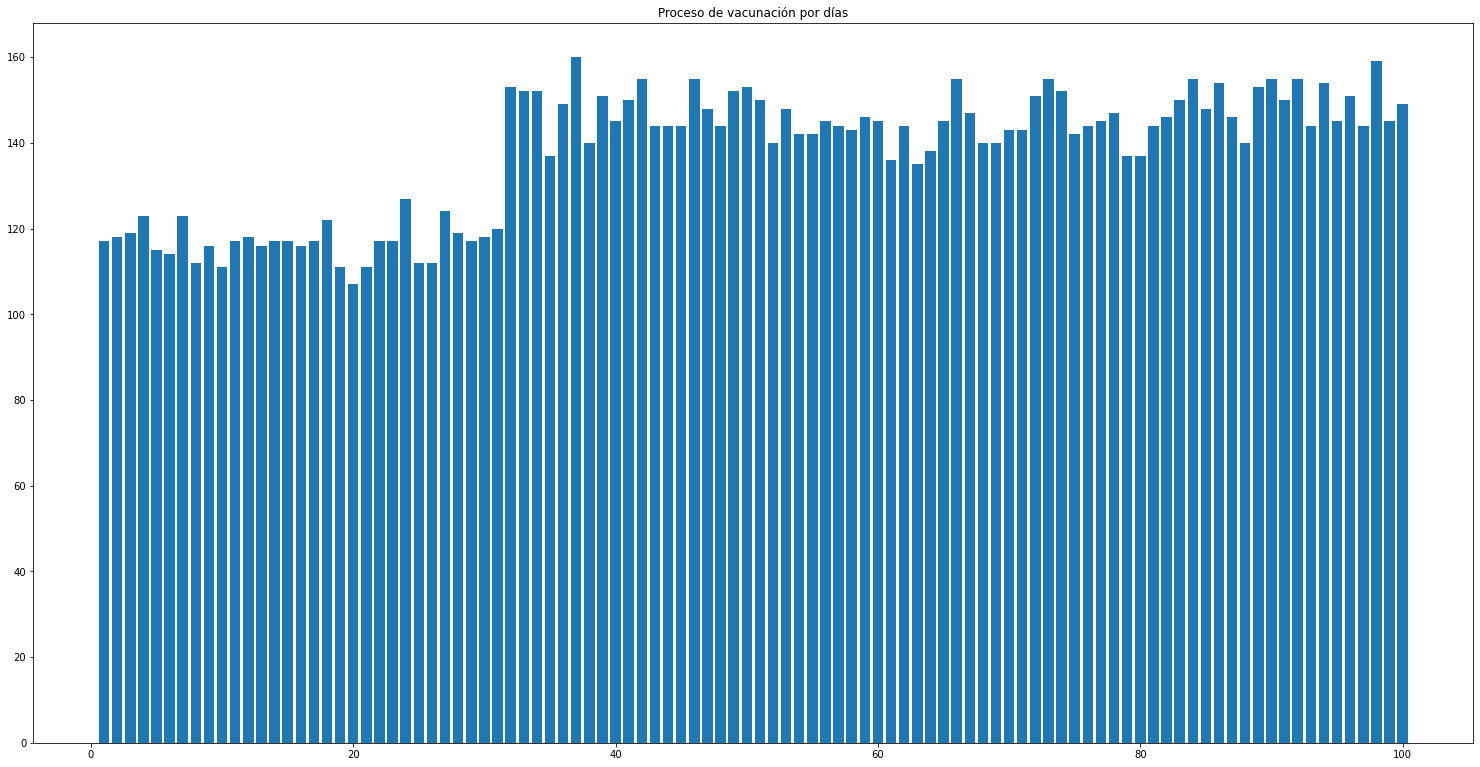

<BarContainer object of 3 artists>

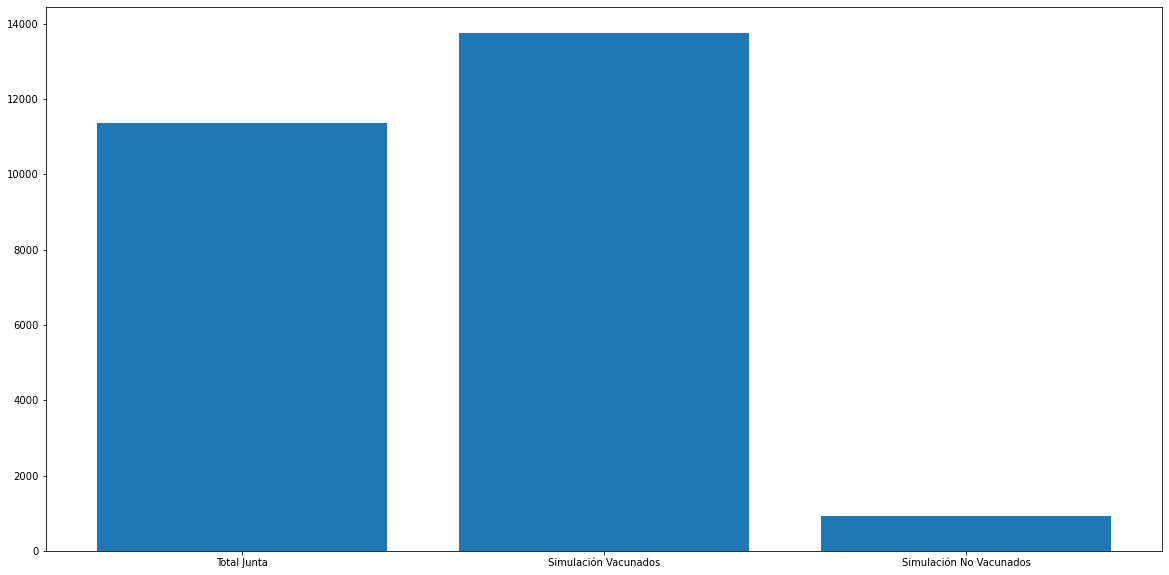

In [6]:
# Gráfica y resultados
fig = plt.figure(figsize=(20,10))

ax = fig.add_axes([0,0,1,1])
ax.bar(proceso['dia'], proceso['vacunados'])
plt.title('Proceso de vacunación por días')
plt.show()

ax1 = plt.figure(figsize=(20,10))
total_poblacion = 17700000 * 80 / 100
total_junta = 14211 * 80 / 100
total = sum(proceso['vacunados'])
total_noVacuna = sum(proceso['no_vacunados'])

labels = ['Total Junta', 'Simulación Vacunados', 'Simulación No Vacunados']
datos = [total_junta, total, total_noVacuna]

plt.bar(labels, datos)